In [1]:
import keras

Using TensorFlow backend.


In [2]:
# getting the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import glob

In [3]:
# Get the input and output file lists
input_path = '../data/processed/cseg_fault_dyke_fold_model_100/input/'
output_path = '../data/processed/cseg_fault_dyke_fold_model_100/output/'

list_of_files_input = glob.glob(input_path + '*')
list_of_files_output = glob.glob(output_path + '*')

n_images = len(list_of_files_input)
print('No. of samples : ', n_images)
    

No. of samples :  44800


In [4]:
# read the data
input_data = np.empty([n_images, 100, 100])
output_data = np.empty([n_images, 100, 100])
count = 0
for count in range(n_images):
    input_data[count, :, :] = np.load(list_of_files_input[count])
    output_data[count, :, :] = np.load(list_of_files_output[count])

In [5]:
print(output_data.shape)

(44800, 100, 100)


In [6]:
# Scaling the data between 0 and 1 based on noise free
img_max = np.max(output_data)
img_min = np.min(output_data)

img_diff = img_max - img_min

output_data = (output_data - img_min) / img_diff
input_data = (input_data - img_min) / img_diff
print(np.max(input_data), np.min(input_data), np.max(output_data), np.min(input_data))

2.505331809532553 0.0 1.0 0.0


In [7]:
import keras
from sklearn.model_selection import train_test_split

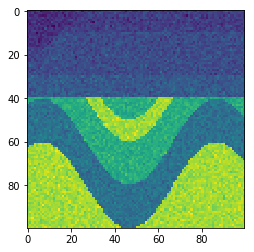

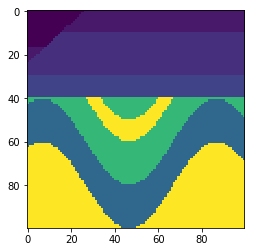

In [8]:
# Randomly visualizing a certain sample
sample_index = 29
f = plt.figure(1)
plt.imshow(input_data[sample_index, :, :])
g = plt.figure(2)
plt.imshow(output_data[sample_index, :, :])

In [44]:
# Splitting the data into training and validation sets
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_data, test_size = 0.2, random_state = seed)

MemoryError: 

In [10]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(17920, 50, 50) (17920, 50, 50) (4480, 50, 50) (4480, 50, 50)


In [11]:
# Creating the convolutional autoencoder
from keras import Input, Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
def design_convolutional_autoencoder():
    # Encoding component
    inputs = Input(shape = (50, 50, 1))
    Z = Conv2D(16, 3, activation = 'relu', padding = 'same')(inputs)
    Z = MaxPooling2D(padding = 'same')(Z)
    Z = Conv2D(8, 3, activation = 'relu', padding = 'same')(Z)
    Z = MaxPooling2D(padding = 'same')(Z)
    Z = Conv2D(8, 3, activation = 'relu', padding = 'same')(Z)
    encoded = MaxPooling2D(padding='same')(Z)    
    
    # decoding
    Z = Conv2D( 8, 3, activation='relu', padding='same')(encoded)
    Z = UpSampling2D()(Z)
    Z = Conv2D( 8, 3, activation='relu', padding='same')(Z)
    Z = UpSampling2D()(Z)
    Z = Conv2D(16, 3, activation='relu')(Z) # <= padding='valid'!
    Z = UpSampling2D()(Z)
    decoded = Conv2D(1, 3, activation='sigmoid', padding='valid')(Z)
    
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return autoencoder

# creating the autoencoder
autoencoder = design_convolutional_autoencoder()
    

In [12]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 8)           0         
__________

In [13]:
# Expanding dimensions of data
X_train1 = np.expand_dims(X_train, axis = 3)
X_test1 = np.expand_dims(X_test, axis = 3)
Y_train1 = np.expand_dims(Y_train, axis = 3)
Y_test1 = np.expand_dims(Y_test, axis = 3)

In [14]:
np.sum(np.isnan(X_train1))

0

In [15]:
# training the autoecoder model
autoencoder.fit(X_train1, Y_train1, epochs = 100, batch_size=200, validation_data=(X_test1, Y_test1))

Train on 17920 samples, validate on 4480 samples
Epoch 1/100
17920/17920 [==============================] - 87s 5ms/step - loss: 0.0622 - val_loss: 0.0272
Epoch 2/100
17920/17920 [==============================] - 18s 996us/step - loss: 0.0207 - val_loss: 0.0166
Epoch 3/100
17920/17920 [==============================] - 18s 996us/step - loss: 0.0147 - val_loss: 0.0134
Epoch 4/100
17920/17920 [==============================] - 18s 997us/step - loss: 0.0125 - val_loss: 0.0121
Epoch 5/100
17920/17920 [==============================] - 18s 996us/step - loss: 0.0114 - val_loss: 0.0109
Epoch 6/100
17920/17920 [==============================] - 18s 996us/step - loss: 0.0105 - val_loss: 0.0101
Epoch 7/100
17920/17920 [==============================] - 18s 998us/step - loss: 0.0098 - val_loss: 0.0096
Epoch 8/100
17920/17920 [==============================] - 18s 995us/step - loss: 0.0092 - val_loss: 0.0090
Epoch 9/100
17920/17920 [==============================] - 18s 994us/step - loss: 0.0088 

Epoch 77/100
17920/17920 [==============================] - 35s 2ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 78/100
17920/17920 [==============================] - 35s 2ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 79/100
17920/17920 [==============================] - 35s 2ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 80/100
17920/17920 [==============================] - 35s 2ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 81/100
17920/17920 [==============================] - 30s 2ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 82/100
17920/17920 [==============================] - 28s 2ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 83/100
17920/17920 [==============================] - 28s 2ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 84/100
17920/17920 [==============================] - 28s 2ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 85/100
17920/17920 [==============================] - 31s 2ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 86/100
17920/17920 [===========

In [16]:
print(np.min(input_data))

0.0


In [17]:
print(np.min(output_data))

0.0


In [18]:
Y_predicted = autoencoder.predict(X_test1)

0.0 1.3687345880814543
0.0 1.0
0.0009263217 1.0


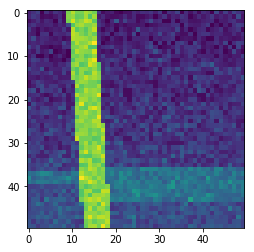

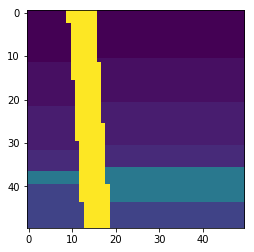

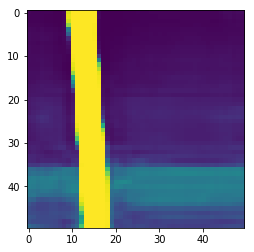

In [26]:
# Randomly visualizing a certain sample
sample_index = 100
f = plt.figure(1)
plt.imshow(X_test1[sample_index, :, :, 0])
print(np.min(X_test1[sample_index, :, :, 0]), np.max(X_test1[sample_index, :, :, 0]))
f1 = plt.figure(2)
plt.imshow(Y_test1[sample_index, :, :, 0])
print(np.min(Y_test1[sample_index, :, :, 0]), np.max(Y_test1[sample_index, :, :, 0]))
g = plt.figure(3)
plt.imshow(Y_predicted[sample_index, :, :, 0])
print(np.min(Y_predicted[sample_index, :, :, 0]), np.max(Y_predicted[sample_index, :, :, 0]))

In [27]:
## serialize model to JSON
model_json = autoencoder.to_json()
with open("model_1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights("model_1.h5")
print("Saved model to disk")

Saved model to disk
